In [1]:
import time

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'src')

import utils, eval_utils

## Utilities

In [2]:
# get paths of images in dataset
rgbd_data_path = '../RGBD_dataset'
image_paths = [str(file) for file in utils.get_files_in_dir(utils.pathlib.Path(rgbd_data_path)) if utils.is_rgb_im(file)]
image_paths_train = [str(file) for file in utils.get_files_in_dir(utils.pathlib.Path(rgbd_data_path + '/train')) if utils.is_rgb_im(file)]
image_paths_train = [str(file) for file in utils.get_files_in_dir(utils.pathlib.Path(rgbd_data_path + '/test')) if utils.is_rgb_im(file)]

In [3]:
def load_images(im_base_path):
    '''load rgb, depth, hha, and mask images from base path'''
    bgr_image = cv.imread(f'{im_base_path}.png', cv.IMREAD_UNCHANGED)
    rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB) # convert from openCV's BGR form to RGB

    depth_image = cv.imread(f'{im_base_path}_depth.png', cv.IMREAD_UNCHANGED)
    hha_image = cv.imread(f'{im_base_path}_depth_hha.png', cv.IMREAD_UNCHANGED)
    mask_image = cv.imread(f'{im_base_path}_mask.png', cv.IMREAD_UNCHANGED)

    return rgb_image, depth_image, hha_image, mask_image

In [4]:
def plot_rgb_depth(rgb_im, depth_im, hha_im, mask_image=None):
    '''plots rgb, depth, hha, and mask images next to each other'''
    
    if mask_image is None:
        fig, (rgb_ax, depth_ax, hha_ax) = plt.subplots(nrows=1, ncols=3, figsize=[16, 7])

        rgb_ax.imshow(rgb_im);
        rgb_ax.set_title('RGB Image')

        idepth_ax.imshow(depth_im, cmap='binary');
        depth_ax.set_title('Depth Image')

        hha_ax.imshow(hha_im);
        hha_ax.set_title('Geocentric Embedding');
    else:
        fig, (rgb_ax, depth_ax, hha_ax, mask_ax) = plt.subplots(nrows=1, ncols=4, figsize=[21,7])

        rgb_ax.imshow(rgb_im);
        rgb_ax.set_title('RGB Image')

        depth_ax.imshow(depth_im, cmap='binary');
        depth_ax.set_title('Depth Image');

        hha_ax.imshow(hha_im);
        hha_ax.set_title('Geocentric Embedding');       

        mask_ax.imshow(mask_image, cmap='binary');
        mask_ax.set_title('Binary mask')       
         

    return fig

In [5]:
im_base_path = '../RGBD_dataset/train/apple/apple_2_1_1'

rgb_image, depth_image, hha_image, mask_image = load_images(im_base_path)

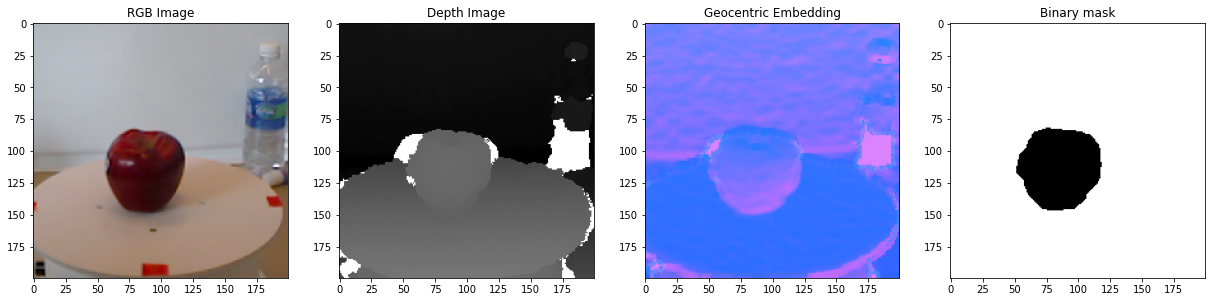

In [6]:
fig = plot_rgb_depth(rgb_image, depth_image, hha_image, mask_image=mask_image);
#fig.set_size_inches([15, 5])

## Load dataset(s)

In [7]:
start_time = time.time()

print('loading hha train and test datasets')
train_data_path = 'C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGBD_dataset' + '/train'
test_data_path = 'C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGBD_dataset' + '/test'

# rgbd_train_dataset = utils.create_rgbd_dataset(train_data_path, azure=False)
rgbd_test_dataset = utils.create_rgbd_dataset(test_data_path, azure=False)

print(f'done! took {time.time()-start_time:.2f} seconds')

loading hha train and test datasets
done! took 35.84 seconds


In [8]:
classes = list(rgbd_test_dataset.label_int_dict.keys())
ind_class_dict = {i: c for c, i in rgbd_test_dataset.label_int_dict.items()}

# Loading Models

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

import hha_model, depth_model, rgb_model, rgbd_model, rgb_hha_model 

In [10]:
# r50x1_loc = "https://tfhub.dev/google/bit/m-r50x1/1"
r50x1_loc = "models/bit_m-r50x1_1"
rgb_resnet = hub.KerasLayer(r50x1_loc, name='feat_vec_embedding', trainable=False)

In [11]:
# build models from architecture definition

depth_mdl = depth_model.build_model((200,200), 51)

hha_mdl = hha_model.build_model((200,200), 51)

rgb_mdl = rgb_model.build_model((200,200), 51, rgb_resnet)

rgbd_mdl = rgbd_model.build_model((200,200), 51, rgb_resnet)

hha_feat_extractor = rgb_hha_model.build_hha_feature_extractor(weights='src/models_archive/hha_run2_epoch6_weights.h5', trainable=True)
rgb_hha_mdl = rgb_hha_model.build_rgb_hha_model(input_shape=(200,200), num_classes=51, 
                    hha_feat_vec_embedding=hha_feat_extractor, rgb_feat_vec_embedding=rgb_resnet, 
                    model_name='rgb-hha_model')

In [12]:
# load trained weights
weights_dir = 'src/models_archive'
depth_weights = 'depth_model_run3_epoch4_weights.h5'
hha_weights = 'hha_run2_epoch6_weights.h5'
rgb_weights = 'rgb_model_run3_weights.h5'
rgbd_weights = 'rgbd_model_run29_epoch3_weights.h5'
rgb_hha_weights = 'rgb_hha_model_run11_epoch7_weights.h5'

depth_mdl.load_weights(f'{weights_dir}/{depth_weights}')
hha_mdl.load_weights(f'{weights_dir}/{hha_weights}')
rgb_mdl.load_weights(f'{weights_dir}/{rgb_weights}')
rgbd_mdl.load_weights(f'{weights_dir}/{rgbd_weights}')
rgb_hha_mdl.load_weights(f'{weights_dir}/{rgb_hha_weights}')

# DEMO

In [13]:
rand_img_path = np.random.choice(image_paths)
print('randomly chose: ', rand_img_path)

randomly chose:  ..\RGBD_dataset\train\water_bottle\water_bottle_3_4_6.png


In [14]:
im_base_path = rand_img_path[:-4]
rgb_image, depth_image, hha_image, mask_image = load_images(im_base_path)

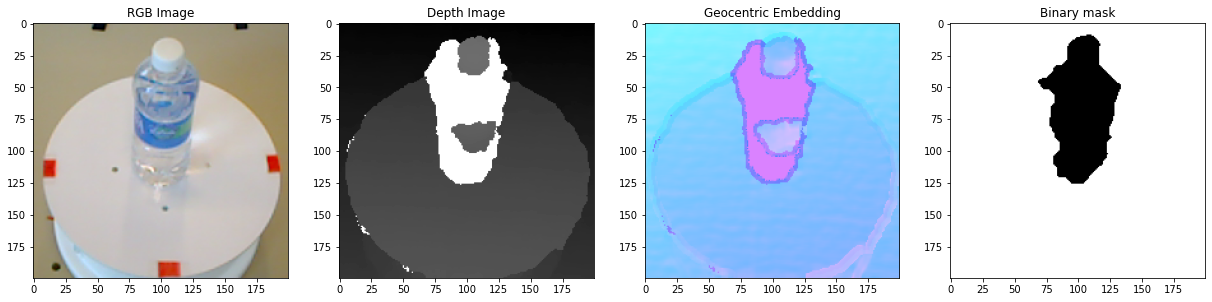

In [15]:
fig = plot_rgb_depth(rgb_image, depth_image, hha_image, mask_image=mask_image);
#fig.set_size_inches([, ])

In [16]:
rgb_image = utils.load_rgb_img_from_path(rand_img_path)
depth_image = utils.load_depth_img_from_path(rand_img_path)
hha_image = utils.load_hha_img_from_path(rand_img_path)

In [18]:
pred_rgb = eval_utils.predict_class(rgb_mdl, [rgb_image], class_dict=ind_class_dict)[0]
print(f'rgb model\'s prediction: {pred_rgb}')

pred_depth = eval_utils.predict_class(depth_mdl, [depth_image], class_dict=ind_class_dict)[0]
print(f'depth model\'s prediction: {pred_depth}')

pred_hha = eval_utils.predict_class(hha_mdl, [hha_image], class_dict=ind_class_dict)[0]
print(f'hha model\'s prediction: {pred_hha}')

pred_rgbd = eval_utils.predict_class(rgbd_mdl, [rgb_image, depth_image], class_dict=ind_class_dict)[0]
print(f'rgb-d model\'s prediction: {pred_rgbd}')

pred_rgb_hha = eval_utils.predict_class(rgb_hha_mdl, [rgb_image, hha_image], class_dict=ind_class_dict)[0]
print(f'rgb-hha model\'s prediction: {pred_rgb_hha}')

rgb model's prediction: water_bottle
depth model's prediction: soda_can
hha model's prediction: water_bottle
rgb-d model's prediction: water_bottle
rgb-hha model's prediction: water_bottle
